#Google Drive Authetication



In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installing Transformers

In [ ]:
!pip install transformers==3.0.0

     |████████████████████████████████| 754 kB 23.7 MB/s 
     |████████████████████████████████| 3.0 MB 44.1 MB/s 
     |████████████████████████████████| 1.2 MB 47.2 MB/s 
     |████████████████████████████████| 895 kB 65.5 MB/s 


#Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim import lr_scheduler
from bs4 import BeautifulSoup 

import pandas as pd
import numpy as np
import os
import shutil

import logging
logging.basicConfig(level=logging.ERROR)

#import warnings
#warnings.filterwarnings("ignore")

#GPU device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cpu


#xml to csv of train data

In [ ]:
file = open("drive/MyDrive/train.xml",'r')
contents = file.read()

In [ ]:
doc = BeautifulSoup(contents,'xml')

In [ ]:
text_ = doc.find_all('text')
aspectCategories = doc.find_all('aspectCategories')

In [ ]:
text_list = []
categ_list=[]
polarity_list=[]
for i in range(len(text_)):
   t= text_[i].get_text()
   acs=aspectCategories[i].find_all('aspectCategory')
   for j in range(len(acs)):
     categ= acs[j]['category']
     prior= acs[j]['polarity']
     text_list.append(t)
     categ_list.append(categ)
     polarity_list.append(prior)
df = pd.DataFrame(list(zip(text_list, categ_list,polarity_list)),
               columns =['text', 'aspect_category','polarity'])


In [ ]:
df.to_csv('train.csv',index=False)

In [ ]:
df.head()

,text,aspect_category,polarity
0,It might be the best sit down food I've had in...,food,positive
1,It might be the best sit down food I've had in...,place,neutral
2,Hostess was extremely accommodating when we ar...,staff,positive
3,Hostess was extremely accommodating when we ar...,miscellaneous,neutral
4,We were a couple of minutes late for our reser...,miscellaneous,neutral


In [ ]:
train = pd.read_csv("train.csv")
train.head()

,text,aspect_category,polarity
0,It might be the best sit down food I've had in...,food,positive
1,It might be the best sit down food I've had in...,place,neutral
2,Hostess was extremely accommodating when we ar...,staff,positive
3,Hostess was extremely accommodating when we ar...,miscellaneous,neutral
4,We were a couple of minutes late for our reser...,miscellaneous,neutral


In [ ]:
len_=train.shape[0] 
lst = list(np.arange(0,len_))
train['id']=lst
first_column = train.pop('id')
train.insert(0, 'id', first_column)

In [ ]:
train.head()

,id,text,aspect_category,polarity
0,0,It might be the best sit down food I've had in...,food,positive
1,1,It might be the best sit down food I've had in...,place,neutral
2,2,Hostess was extremely accommodating when we ar...,staff,positive
3,3,Hostess was extremely accommodating when we ar...,miscellaneous,neutral
4,4,We were a couple of minutes late for our reser...,miscellaneous,neutral


In [ ]:
aspects = ["food", "staff", "miscellaneous", "place","service","menu","ambience","price"]

In [ ]:
train.aspect_category.value_counts()

food             2297
staff            1379
miscellaneous     947
place             693
service           630
menu              469
ambience          322
price             319
Name: aspect_category, dtype: int64

#Aspect Count Distribution

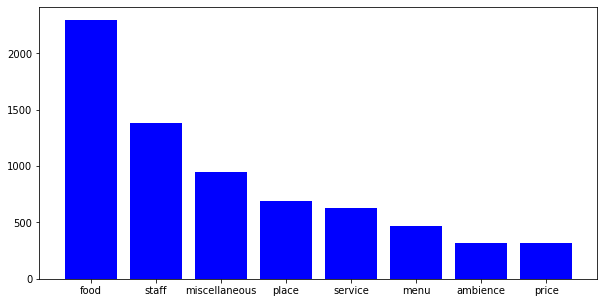

In [ ]:
data = {'food': 2297, 'staff': 1379,"miscellaneous":947,"place":693,"service":630,"menu":469,"ambience":322,"price":319}
names = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(range(len(data)), values, tick_label=names,color="blue")
plt.show()

#Reformat Data

In [ ]:
def reformat_data(data):
  path="train_folder"
  if not os.path.exists(path):
      os.makedirs(path)

  path="validation_folder"
  if not os.path.exists(path):
      os.makedirs(path)
      
  for aspect in aspects:
    df_new = data[data['aspect_category'] ==aspect]
    df_new=df_new.drop(['aspect_category'], axis = 1)

    train_len = int(df_new.shape[0]*0.6)
    train_data = df_new.iloc[:train_len,:]
    valid_data=df_new.iloc[train_len:,:]

    
    train_file_name = "train_folder/"+aspect+".csv"
    valid_file_name = "validation_folder/"+aspect+".csv"
    
    train_data.to_csv(train_file_name,index=False)
    valid_data.to_csv(valid_file_name,index=False)
    

In [ ]:
reformat_data(train)

In [ ]:
'''
import os
to_be_deleted = ["validation folder","train_folder"]

#path = "tiny-imagenet-200/train/"
for folder in to_be_deleted:
    shutil.rmtree(folder)
'''

#BERT Model

In [ ]:
class SentimentClassifier(nn.Module):
  """
  This class defines the model architecture which is simply a fully-connected
  layer on top of a pre-trained BERT model. 
  """

  def __init__(self, BERT_MODEL):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, 3) # Number of output classes = 3

  def forward(self, ids, mask, token_type_ids):
    last_hidden_state, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
from torchsummary import summary
BERT_MODEL = 'bert-base-uncased'
model = SentimentClassifier(BERT_MODEL)
model = model.to(device)


In [ ]:
print(model)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [ ]:
class util_tokenizer:
  """
  This class tokenizes the input text using the pre-trained BERT tokenizer 
  (wordpiece) and returns the corresponding tensors.
  """

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.targets = targets

  def __len__(self):
    return len(self.targets)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    targets = self.targets[item]

    inputs = self.tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        pad_to_max_length = True
    )

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

In [ ]:
def loss_function(outputs, targets):
	"""
	This function defines the loss function which is used to train the model, i.e.
	CrossEntropy.
	"""
	return nn.CrossEntropyLoss(reduction='mean')(outputs, targets)

In [ ]:
def train_loop_function(data_loader, model, optimizer, device,  aspect):
  """
  This function defines the training loop over the entire training set.
  """

  model.train()
  loss_list =[]
  running_loss = 0.0
  for bi, d in enumerate(data_loader):
    ids = d["ids"]
    mask = d["mask"]
    token_type_ids = d["token_type_ids"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.long)

    optimizer.zero_grad()

    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    loss = loss_function(outputs, targets)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if bi % 10 == 0 and bi!=0:
      temp = f'Batch index = {bi}\tLoss = {running_loss/10}'
      loss_list.append(running_loss/10)
      running_loss = 0.0
  return loss_list


In [ ]:
def eval_loop_function(data_loader, model, device, aspect):
  """
  This function defines the evaluation loop over the entire validation set.
  It also computes accuracy of the trained model, which is used to select the 
  best model.
  """

  model.eval()

  corrects = 0
  total = 0
  for bi, d in enumerate(data_loader):
    ids = d["ids"]
    mask = d["mask"]
    token_type_ids = d["token_type_ids"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.long)

    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

    _, predicted = torch.max(outputs, 1)
    total = total + targets.size(0)
    corrects = corrects + (predicted==targets).sum().item()

    #print(f"bi: {bi}\tPredicted: {predicted}\tTargets: {targets}")

  accuracy = corrects / total * 100
  return accuracy

In [ ]:
def run():
  """
  This function defines hyperparameters, model and optimizer, loads required
  datasets and initiate the training and validation procedures.
  """
  

  accuracy_dict={}
  final_model=None


  TRAIN_MAX_LEN = 140
  VALID_MAX_LEN = 140
  TRAIN_BATCH_SIZE = 16
  VALID_BATCH_SIZE = 16
  EPOCHS = 10
  BERT_MODEL = 'bert-base-uncased'
  LEARNING_RATE = 3e-5

  aspects = ["food", "staff", "miscellaneous", "place","service","menu","ambience","price"]
  # Train and validate a model for every `location-aspect` using corresponding 
  # datasets.

  
  for aspect in aspects:
          print(f"Starting {aspect}...")

          path = "/content/drive/MyDrive/NLU2/"+aspect

          if not os.path.exists(path):
                 os.makedirs(path)

          accuracy_aspect_wise=[]
          training_set_path = 'train_folder/' + str(aspect) + '.csv'
          validation_set_path = 'validation_folder/' +str(aspect) + '.csv'

          df_train = pd.read_csv(training_set_path)
          df_valid = pd.read_csv(validation_set_path)
          sentiment_mapping = {
              'positive': 0,
              'negative': 1,
              'neutral': 2
          }
          df_train['polarity'] = df_train['polarity'].map(sentiment_mapping)
          df_valid['polarity'] = df_valid['polarity'].map(sentiment_mapping)
          df_train = df_train.reset_index(drop=True)
          df_valid = df_valid.reset_index(drop=True)

          tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL)

          train_dataset = util_tokenizer(
              text = df_train['text'].values,
              targets = df_train['polarity'].values,
              tokenizer = tokenizer,
              max_len = TRAIN_MAX_LEN
          )


          class_counts = []
          for i in range(3):
            class_counts.append(df_train[df_train['polarity']==i].shape[0])
          
          
          num_samples = sum(class_counts)
          labels = df_train['polarity'].values
        

          class_counts=list(class_counts)
          class_weights = []

          for i in range(3):

            if class_counts[i] != 0:
              class_weights.append(num_samples/class_counts[i])
            else:
              class_weights.append(0)

          weights = [class_weights[labels[i]] for i in range(int(num_samples))]
          sampler = torch.utils.data.sampler.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


          train_data_loader = torch.utils.data.DataLoader(
              train_dataset,
              batch_size = TRAIN_BATCH_SIZE,
              shuffle = False,
              sampler = sampler
          )

          valid_dataset = util_tokenizer(
              text = df_valid['text'].values,
              targets = df_valid['polarity'].values,
              tokenizer = tokenizer,
              max_len = VALID_MAX_LEN
          )

          valid_data_loader = torch.utils.data.DataLoader(
              valid_dataset,
              batch_size = VALID_BATCH_SIZE,
              shuffle = False
          )

          model = SentimentClassifier(BERT_MODEL)
          model = model.to(device)

          

          num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
          optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

          scheduler = lr_scheduler.StepLR(
              optimizer,
              step_size = 1,
              gamma = 0.8
          )
          max_accuracy=-999
          for epoch in range(EPOCHS):
                print(epoch)
                loss_list= train_loop_function(data_loader=train_data_loader, model=model, optimizer=optimizer, device=device,  aspect=aspect)
                accuracy = eval_loop_function(data_loader=valid_data_loader, model=model, device=device, aspect=aspect)
                accuracy_aspect_wise.append(accuracy)
                if accuracy>max_accuracy :
                        max_accuracy=accuracy
                        final_model = model
                        model_name = '/content/drive/MyDrive/NLU2/' + str(aspect) + '/'+ str(epoch) + '.bin'
                        #epoch , accuracy in that epoch, loss batch wise 
                        accuracy_dict[aspect]= [epoch,accuracy,loss_list]

                print(f"\nEpoch = {epoch}\tAccuracy Score = {accuracy}")
                print(f"Learning Rate = {scheduler.get_lr()[0]}\n")
                print("loss_list ",loss_list,sep= " ")

                scheduler.step()

          accuracy_dict[aspect].append(accuracy_aspect_wise)
          torch.save(final_model,model_name)     
  return accuracy_dict


In [ ]:
if __name__ == "__main__":
  accuracy_dict = run()

In [ ]:
aspects = ["food", "staff", "miscellaneous", "place","service","menu","ambience","price"]
for aspect in aspects:
  best_epoch = accuracy_dict[aspect][0]
  best_accuracy = accuracy_dict[aspect][1]
  losses=accuracy_dict[aspect][2]
  accuracy_list = accuracy_dict[aspect][3]
  plt.plot(losses)
  plt.xlabel("epoch") 
  plt.ylabel("loss")
  title= aspect+" epoch "+str(best_epoch)+" epoch vs loss graph"
  plt.title(title)
  plt.show()

  plt.plot(accuracy_list)
  plt.xlabel("epoch") 
  plt.ylabel("accuracy")
  title= aspect+" epoch "+str(best_epoch)+" epoch vs accuracy graph"
  plt.title(title)
  plt.show()
  

In [ ]:
accuracy_dict

In [ ]:
labels_to_sentiment_dict = {
    0: 'positive',
    1: 'negative',
    2: 'neutral'
}
sentiment_to_labels_dict={
    'positive':0,
    'negative':1,
    'neutral':2

}

In [ ]:
import os
aspects = ["food", "staff", "miscellaneous", "place","service","menu","ambience","price"]

# models_dict:Is a dictionary containing models corresponding to all the 
# `location-aspect`.

models_dict = {}


for aspect in aspects:
  path = "/content/drive/MyDrive/NLU2/"+str(aspect)+"/"
  dir_list = os.listdir(path)
  path=path+dir_list[0]
  model = torch.load(path, map_location='cpu')
  model= model.to(device)
  models_dict[f"{aspect}"] = model

#Test data from xml to csv

In [ ]:
file = open("drive/MyDrive/text.xml",'r')
contents = file.read()

In [ ]:
doc = BeautifulSoup(contents,'xml')

In [ ]:
text_ = doc.find_all('text')

In [ ]:
text_list = []
for i in range(len(text_)):
   t= text_[i].get_text()
   text_list.append(t)
  
df = pd.DataFrame(list(zip(text_list)),
               columns =['text'])

In [ ]:
df.head()

,text
0,"Overall, it is a nice place and if you don't m..."
1,"We waited 15 minutes for a menu, another 20 fo..."
2,the dishes are a little too recherche and too ...
3,The pricing isn't quite clear and look out for...
4,"the menu looked great, but the food was the bi..."


In [ ]:
df.to_csv("test.csv",index=False)

In [ ]:
testing_set = pd.read_csv("test.csv")

In [ ]:
id=[i for i in range(0,len(testing_set))]
testing_set['id']=id

In [ ]:
testing_set.head()

,text,id
0,"Overall, it is a nice place and if you don't m...",0
1,"We waited 15 minutes for a menu, another 20 fo...",1
2,the dishes are a little too recherche and too ...,2
3,The pricing isn't quite clear and look out for...,3
4,"the menu looked great, but the food was the bi...",4


In [ ]:
BERT_MODEL = 'bert-base-uncased'
MAX_LEN = 160

tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL)
model_pred=[]
score=[]
aspect_category=[]
text_list=[]
test_id=[]
polarity=[]


for each_example in testing_set.itertuples():
  id = int(each_example.id)
  text_=each_example.text
  text = each_example.text.strip()
  each_example=list(each_example)


  for aspect in aspects:
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = MAX_LEN,
        pad_to_max_length = True
    )
    ids = torch.tensor(inputs["input_ids"], dtype=torch.long).unsqueeze(0)
    mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).unsqueeze(0)
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0)

    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)

    model = models_dict[f"{aspect}"]
    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
 

    _, predicted = torch.max(outputs, 1)

    predicted = predicted.detach().cpu().numpy()
    predict_polarity=predicted[0]
    predict_score=outputs[0][predict_polarity].item()

    #append
    score.append(predict_score)
    test_id.append(id)
    aspect_category.append(aspect)
    text_list.append(text_)

    polarity.append(predicted[0])




Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
dict_ = {'id': test_id, 'text': text_list, 'aspect': aspect_category,'aspect_score':score,'polarity':polarity} 
df = pd.DataFrame(dict_)

In [ ]:
df.aspect_score = (df.aspect_score - np.min(df.aspect_score))/(np.max(df.aspect_score)-np.min(df.aspect_score))
print(df)

     id                                               text         aspect  \
0     0  Overall, it is a nice place and if you don't m...           food   
1     0  Overall, it is a nice place and if you don't m...          staff   
2     0  Overall, it is a nice place and if you don't m...  miscellaneous   
3     0  Overall, it is a nice place and if you don't m...          place   
4     0  Overall, it is a nice place and if you don't m...        service   
..   ..                                                ...            ...   
115  14  The staff were rude and rushed us through our ...          place   
116  14  The staff were rude and rushed us through our ...        service   
117  14  The staff were rude and rushed us through our ...           menu   
118  14  The staff were rude and rushed us through our ...       ambience   
119  14  The staff were rude and rushed us through our ...          price   

     aspect_score  polarity  
0        0.737899         2  
1        0.1969

In [ ]:
polarity_new=[]
for each_example in df.itertuples():
  if each_example.polarity==0:
    polarity_new.append("positive")
  elif each_example.polarity==1:
    polarity_new.append("negative")
  else:
    polarity_new.append("neutral")

df['polarity']=polarity_new
predicted_df= df[df.aspect_score>=0.4]
print(predicted_df)

     id                                               text         aspect  \
0     0  Overall, it is a nice place and if you don't m...           food   
2     0  Overall, it is a nice place and if you don't m...  miscellaneous   
3     0  Overall, it is a nice place and if you don't m...          place   
8     1  We waited 15 minutes for a menu, another 20 fo...           food   
9     1  We waited 15 minutes for a menu, another 20 fo...          staff   
10    1  We waited 15 minutes for a menu, another 20 fo...  miscellaneous   
11    1  We waited 15 minutes for a menu, another 20 fo...          place   
12    1  We waited 15 minutes for a menu, another 20 fo...        service   
17    2  the dishes are a little too recherche and too ...          staff   
21    2  the dishes are a little too recherche and too ...           menu   
24    3  The pricing isn't quite clear and look out for...           food   
25    3  The pricing isn't quite clear and look out for...          staff   

In [ ]:
predicted_df.to_csv("hello.csv",index=False)

In [ ]:
df=pd.read_csv("hello.csv")

In [ ]:
df.head()

,id,text,aspect,aspect_score,polarity
0,0,"Overall, it is a nice place and if you don't m...",food,0.737899,neutral
1,0,"Overall, it is a nice place and if you don't m...",miscellaneous,0.460248,positive
2,0,"Overall, it is a nice place and if you don't m...",place,0.580446,positive
3,1,"We waited 15 minutes for a menu, another 20 fo...",food,0.820102,neutral
4,1,"We waited 15 minutes for a menu, another 20 fo...",staff,0.880141,negative
